# Experiment Tracking and Model Management

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

<!-- Place this tag where you want the button to render. -->
<a class="github-button" href="https://github.com/particle1331/steepest-ascent" data-color-scheme="no-preference: dark; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="true" aria-label="Star particle1331/steepest-ascent on GitHub">Star</a>
<!-- Place this tag in your head or just before your close body tag. -->
<script async defer src="https://buttons.github.io/buttons.js"></script> 


In this module, we will look **experiment tracking** and **model management**. A machine learning experiment is defined as a session or process of making machine learning models. Experiment tracking is the process of keeping track of all relevant information in an experiments. This includes source code, environment, data, models, hyperparameters, and so on which are important for reproducing the experiment as well as for making actual predictions. 

From experience, we know that manual tracking, e.g. with spreadsheets, is error prone, not standardized, has low visibility, and difficult for teams to collaborate over. As an alternative, we will experiment tracking platforms such as [MLFlow](https://mlflow.org/). MLFlow has four main components: tracking, models, model registry, and projects. In this course, we only be cover the first three. 

```{margin}
⚠️ **Attribution:** These are notes for [Module 2](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/02-experiment-tracking) of the [MLOps Zoomcamp](https://github.com/DataTalksClub/mlops-zoomcamp). The MLOps Zoomcamp is a free course from [DataTalks.Club](https://github.com/DataTalksClub).
```

As we have seen with our previous prototyping, having the ability to reproduce results is important since we want to have the same results when deploying the model in different environments. Using experiment tracking and model management platforms allows us to have better chance at reproducing our results, as well as aid in organization (staging and deploying models) and optimization (finding the best models). 

## Getting started: MLFlow UI

We can run the MLFlow UI with an SQLite backend as follows:


```bash
$ mlflow ui --backend-store-uri sqlite:///mlflow.db

[2022-05-26 19:35:22 +0800] [92498] [INFO] Starting gunicorn 20.1.0
[2022-05-26 19:35:22 +0800] [92498] [INFO] Listening at: http://127.0.0.1:5000 (92498)
[2022-05-26 19:35:22 +0800] [92498] [INFO] Using worker: sync
[2022-05-26 19:35:22 +0800] [92499] [INFO] Booting worker with pid: 92499
```

For our experiment, we will use our code and data from [Module 1](https://particle1331.github.io/inefficient-networks/notebooks/mlops/1-intro.html). So before doing any run, we either create an **experiment** or connect a run to it if the experiment already exists. This also sets the experiment tracking backend. The same one that is visualized in the UI above.

```{margin}
[`experiment_lr.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_lr.py#L23-L25)
```

```python
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")
```

The next section of the code executes a **single run** of the experiment. Note the logging at the end of the script. Everything that runs inside the following context is a single run:

```{margin}
[`experiment_lr.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_lr.py#L29-L52)
```
```python
with mlflow.start_run():

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Logging
    rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
    rmse_valid = mean_squared_error(y_valid, model.predict(X_valid), squared=False)

    fig = plot_duration_distribution(model, X_train, y_train, X_valid, y_valid)
    fig.savefig('plot.svg')

    mlflow.set_tag('author', 'particle')
    mlflow.set_tag('model', 'baseline')
    
    mlflow.log_param('train_data_path', train_data_path)
    mlflow.log_param('valid_data_path', valid_data_path)
    
    mlflow.log_metric('rmse_train', rmse_train)
    mlflow.log_metric('rmse_valid', rmse_valid)
    
    mlflow.log_artifact(artifacts / 'plot.svg')
    mlflow.log_artifact(artifacts / 'preprocessor.pkl', artifact_path='preprocessing')
```

After running this script, we see in the UI as a single run under the `nyc-tax-experiment` experiment. MLFlow is able to obtain the version from `git` and the user from the system, i.e. the user that is currently logged in. The other values are obtained from the logs. 

```{figure} ../../../img/single-run-mlflow.png
```

If we click on the run, we can see all details about it that were logged. Shown here are the date of the run, the user that executed it, total runtime, the source code used, as well as the git commit hash. Hence, it is best practice to always commit before running experiments. This ties your runs with a specific version of the code. Status `FINISHED` indicates that the script successfully ran. These are useful metadata.

```{figure} ../../../img/mlflow-single-run.png
```

Regarding the details of the trained model, we have parameters which here include only the path of the dataset for training and validation (only paths, no versioning). Most importantly, we can see the logged RMSEs `5.7` (train) and `7.759` (valid). The plot of the distributions of the true and predicted distributions which we logged as a training artifact is also conveniently displayed here. Finally, we log the preprocessor as **artifact** which will be needed for preprocessing test data during inference.

## Experiment tracking

In this section, we go deeper into experiment tracking with MLFlow. We show how to iterate over different models and different parameters. This really just involves wrapping the run function in a loop. The nontrivial part is how to construct the sequence of parameters to loop over. For this we use [Hyperopt](https://hyperopt.github.io/hyperopt/) which implements the [TPE algorithm](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf). We also look at **autologging** which makes logging simpler for frameworks with MLFlow integration (also automates things like logging intermediate values which are awesome).

### Using scikit-learn models

To evaluate different models, we will define a `run` function that takes in parameters that define and configure a run of the experiment. Then, we define a `main` function that controls the runs that will be executed. Here the `model_class` parameter controls which scikit-learn model is used to model the dataset. Note that this connects to the same tracking URI and same experiment.

```{margin}
[`experiment_sklearn.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_sklearn.py)
```
```python
def setup():
    
    [...]

    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment("nyc-taxi-experiment")
    mlflow.sklearn.autolog()


def run(model_class):
    with mlflow.start_run():

        model = model_class()
        model.fit(X_train, y_train)

    [...]


def main():
    for model_class in [
        Ridge,
        RandomForestRegressor, 
        GradientBoostingRegressor,
    ]:
        run(model_class)


if __name__ == "__main__":
    setup()
    main()
```

`GradientBoostingRegressor` has the best validation score:

```{figure} ../../../img/sklearn-results.png
```

### XGBoost

From the previous runs, so far Gradient Boosted Trees has the best performance on this task. So we try out XGBoost next. In this section, we will also show how to select the best model in an experiment. 

As before, we will define a `setup` function which sets up the required datasets and connections, define a run function (here named `objective`), and a `main` function to facilitate the runs. Here the parameters are sampled using the TPE algorithm implemented in Hyperopt, we had to define the search space in the `search_space` dictionary. Finally, we defined command line arguments so we can easily control the details of the runs in the command line.

```{margin}
[`experiment_xgboost.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_xgboost.py)
```
```python
def setup(autolog):

    [...]

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_valid = xgb.DMatrix(X_valid, label=y_valid)

    # Set experiment
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment("nyc-taxi-experiment")
    mlflow.xgboost.autolog(disable=not(autolog))


def objective(params, autolog):
    """Compute validation RMSE (one trial = one run)."""

    with mlflow.start_run():
        
        model = xgb.train(
            params=params,
            dtrain=xgb_train,
            num_boost_round=1000,
            evals=[(xgb_valid, 'validation')],
            early_stopping_rounds=50
        )

        # Logging
        [...]

        if not autolog:
            mlflow.xgboost.log_model(model, 'model')
            mlflow.log_params(params)

    return {'loss': rmse_valid, 'status': STATUS_OK}


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}


def main(autolog, num_runs):
    best_result = fmin(
        fn=partial(objective, autolog=autolog),
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_runs,
        trials=Trials()
    )


if __name__ == "__main__":
    
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--autolog", choices=["False", "True"])
    parser.add_argument("--num_runs", default=1, type=int)
    
    args = parser.parse_args()
    
    # Experiment runs
    autolog = (args.autolog == 'True')
    setup(autolog=autolog)
    main(autolog=autolog, num_runs=args.num_runs)
```

Let's look at the details of a single XGBoost run with autologging, this plots all 14 parameters of XGBoost (much more than what we have in our search space). Also, as before we have feature importances and the `MLModel` file along with the environments files. Moreover the best and stopped iterations are saved (early stopped). We can also view the intermediate values:

```{figure} ../../../img/xgboost-run.png
```

```{figure} ../../../img/xgboost-intermediate.png
```

We executed 30 runs of the XGBoost model (+1 with autologging). This can be analyzed using the compare button after selecting the results with the search query `tags.model = 'xgboost'`. Below we analyze the runs with the parallel coordinate plot. First, we have the specify the parameters and the metric. Then, we can use filters to filter out ranges that result in low objective values. 

```{figure} ../../../img/xgboost-parallel.png
```

In the other tabs, we also have scatter and contour interactive [plotly](https://plotly.com/) plots:

```{figure} ../../../img/xgboost-scatter.png
```

```{figure} ../../../img/xgboost-contour.png
```

To select the best model, first we filter with `tags.model = 'xgboost' and metrics.rmse_valid < 6.4` and order by ascending validation RMSE. This latter operation can be done by simply clicking the column header. Then, we can order be descending `rmse_train` so we get models that overfit less, or we can look at the train duration as well as inference time (not logged). These requirements should be weighed against production requirements.

```{figure} ../../../img/xgboost-select.png
```

## Model management

In this section, we look at **model management**. In addition to experiment tracking, part of model management is to do model versioning and model deployment. Model management using file systems (which typically just involve a file name and date modified) is error prone. There is no versioning and no model lineage. Mode lineage refers to all associations between a model and all components involved in its creation.

**Reading**
* [Model and data lineage in machine learning experimentation](https://aws.amazon.com/blogs/machine-learning/model-and-data-lineage-in-machine-learning-experimentation/)

### Autologging

Recall that the default parameters of the `LinearRegression` model that we used in the first run that we did were not logged. To log these (and more) without doing much work, MLFlow provides the method `mlflow.sklearn.autolog()`. This also automatically logs useful information specific to the framework such all hyperparameters of the model and `estimator_class`. Model artifacts are also saved which can be used to easily deploy trained models tracked using MLFlow. 

```{figure} ../../../img/autologging-2.png
```

```{figure} ../../../img/autologging-1.png
```

`MLModel` stores information about the model, flavors, path (where model lives), and helps serve model as a Python function or a framework model. Also, package versions are stated in both `conda.yaml` and `requirements.txt` files Note that Python version used to train the model is also included. (Note that framework autologging also performs particular things such as save feature importance artifact for XGBoost.)

### Inference

In the following code, we try to perform inference on "new data" using the logged model and artifacts. 
Note that new data has no labels when processed for inference. Since we can't compute metrics, we will check output distribution to show correctness. Recall that the training set used is filtered to include rides  between 1 and 60 minutes in duration. So the following distribution should be close, but not identical:

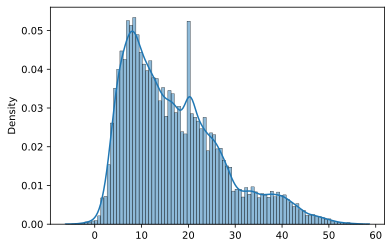

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow
import joblib

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from utils import runs, data_path


# Configure paths to run
run_path = runs / '1' / 'f46f9fedb22c4411b6e265f8e65edbe3'
model_path = run_path / 'artifacts' / 'model'
model_artifacts_path = run_path / 'artifacts' / 'preprocessing'
valid_data_path = data_path / 'green_tripdata_2021-01.parquet'

# Preprocessing test data
feature_pipe = joblib.load(model_artifacts_path / 'preprocessor.pkl')
X = feature_pipe.transform(pd.read_parquet(valid_data_path))

# Make inference using MLFlow file
loaded_model = mlflow.pyfunc.load_model(model_path)
sns.histplot(loaded_model.predict(X),  color='C0', stat='density', kde=True);

**Remarks.** In general, we use `mlflow.<framework>.autolog()` to activate autologging. For frameworks not supported by MLFlow, we can simply log models using `mlflow.log_artifact` on saved pickle files, e.g. using `joblib`. 

## Model registry

New model -> good performance -> plz deploy. 

what has changed? is there any preprocessing needed? what is the environment, what are the dependencies? 

back and fort communication with data scientist.

what if incident in prod, need rollback, need to go to email inbox. imagine its not possible to run this model again, have to retrain from scratch. but what if retraining information is lost, no idea of env used, which dataset, and so on. 

recall we have tracking server, which stored experiment runs. model registry has stages. staging -> prod -> archive. DS only decides which models are ready for prod. deployment engineer not responsible. 

then if we want rollback, we can go back from archive to prod. note that model registry not deployment. it just labels models. need to compliment with ci/cd. in order to do actual deployment. 



comparing models: 
- look at duration, and model size, rmse


information you need to consider

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin


class ConvertToString(BaseEstimator, TransformerMixin):
    """Convert columns of DataFrame to type string."""

    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.features] = X[self.features].astype(str)
        return X


class AddPickupDropoffPair(BaseEstimator, TransformerMixin):
    """Add product of pickup and dropoff locations."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['PU_DO'] = X['PULocationID'].astype(str) + '_' + X['DOLocationID'].astype(str)
        return X


class ConvertToDict(BaseEstimator, TransformerMixin):
    """Convert tabular data to feature dictionaries."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.to_dict(orient='records')


class SelectFeatures(BaseEstimator, TransformerMixin):
    """Convert tabular data to feature dictionaries."""

    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features]


def preprocess_train_targets(data):
    """Derive target and filter outliers."""

    # Create target column and filter outliers
    data['duration'] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
    data['duration'] = data.duration.dt.total_seconds() / 60
    
    X = data[(data.duration >= 1) & (data.duration <= 60)]
    y = X.duration.values
    
    return X, y


In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer

categorical = ['PU_DO']
numerical = ['trip_distance']

pipe = make_pipeline(
    AddPickupDropoffPair(),
    ConvertToString(categorical),
    SelectFeatures(categorical + numerical),
    ConvertToDict(),
    DictVectorizer(),
)

train_data_path =  '../data/green_tripdata_2021-01.parquet'
X_train, y_train = preprocess_train_targets(pd.read_parquet(train_data_path))

pipe.fit_transform(X_train)

<73908x13221 sparse matrix of type '<class 'numpy.float64'>'
	with 147816 stored elements in Compressed Sparse Row format>

In [116]:
AddPickupDropoffPair().transform(X_train)['PU_DO'].nunique() + 1

13221

In [110]:
len(pipe.named_steps['dictvectorizer'].feature_names_)

13221